takehome_user_engagement.csv<br>
takehome_users.csv<br>
The data has the following two tables:<br>
1] A user table ("takehome_users") with data on 12,000 users who signed up for the product in the last two years. This table includes:<br>
● name: the user's name<br>
● object_id: the user's id<br>
● email: email address<br>
● creation_source: how their account was created. This takes on one
of 5 values:<br>
○ PERSONAL_PROJECTS: invited to join another user's personal workspace<br>
○ GUEST_INVITE: invited to an organization as a guest (limited permissions)<br>
○ ORG_INVITE: invited to an organization (as a full member)<br>
○ SIGNUP: signed up via the website<br>
○ SIGNUP_GOOGLE_AUTH: signed up using Google<br>
Authentication (using a Google email account for their login id)<br>
● creation_time: when they created their account<br>
● last_session_creation_time: unix timestamp of last login<br>
● opted_in_to_mailing_list: whether they have opted into receiving
marketing emails<br>
● enabled_for_marketing_drip: whether they are on the regular
marketing email drip<br>
● org_id: the organization (group of users) they belong to<br>
● invited_by_user_id: which user invited them to join (if applicable).<br>
2] A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product.
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period, identify which factors predict future user adoption.<br>

## Data Wrangling

In [30]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl 
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import Counter
%matplotlib inline
#from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import pandas.core.algorithms as algos
import scipy.stats.stats as stats
from sklearn.metrics import log_loss
from sklearn.metrics import average_precision_score
from sklearn.neural_network import MLPClassifier
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import string
%matplotlib inline
mpl.rcParams['patch.force_edgecolor'] = True
sns.set()

In [2]:
user_engagement = pd.read_csv('takehome_user_engagement.csv')

In [3]:
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
user_engagement.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [5]:
# Convert dates to datetime objs
user_engagement['time_stamp'] = list(map(lambda x: datetime.strptime(x.split()[0],'%Y-%m-%d'), user_engagement['time_stamp'])) # also removes hour, min, sec

In [6]:
user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [7]:
user_engagement.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


In [8]:
print("Total number of unique users who have used the app: ",user_engagement['user_id'].nunique())
print( "Total number of logins :",len(user_engagement))


Total number of unique users who have used the app:  8823
Total number of logins : 207917


In [9]:
users = pd.read_csv('takehome_users.csv', encoding = 'latin-1')

In [10]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [17]:
# Convert dates to datetime objs
users['creation_time'] = list(map(lambda x: datetime.strptime(x.split()[0],'%Y-%m-%d'), users['creation_time'])) # also removes hour, min, sec

In [12]:
users.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [13]:
# how many people never signed in?
print('There are ', len(users[users['last_session_creation_time'].isnull()]), 'inactive users.')

There are  3177 inactive users.


## Adopted users

In [14]:
user_timestamps = [] # list of arrays, where each array is a user's logins
for idx, row in users.iterrows():
    user_id = row['object_id']
    timestamps = user_engagement[user_engagement['user_id']==user_id]['time_stamp']
    t = [i for i in timestamps]
    user_timestamps.append(t)

Define a function to identify if a user has logged in 3 separate days in one 7 day period

In [15]:

def adopted(x): # x = list of user's logins ('Timestamp' data type)
    if len(x) < 3:
        return 0
    else:
        x.sort()  
        y = [x[i+1] - x[i] for i in range(len(x)-2)] # amount of days between logins
        y = [i for i in y if i > timedelta(days=0)] # delete extra logins occurring on same day
        z = [1 for i in range(len(y)-2) if y[i] + y[i+1] + y[i+2] <= timedelta(days=7)]
        # condition to check if there`s a 1 in x, return 1 if true
        if 1 in z:
            return 1
        else:
            return 0

In [16]:
adopt_total = []
for user in user_timestamps:
        adopt_total.append(adopted(user))

users['adopted'] = adopt_total

In [18]:
print("Number of adopted users: ", sum(adopt_total))
print("Adopted users: ", sum(adopt_total)/len(adopt_total))

Number of adopted users:  1322
Adopted users:  0.11016666666666666


11% of users are adopted users

0    10678
1     1322
Name: adopted, dtype: int64


/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


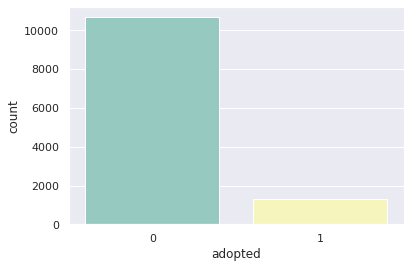

In [20]:
print(users['adopted'].value_counts())
sns.countplot(users['adopted'],palette="Set3")
plt.show()

In [21]:
df = users
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,0
2,3,2013-03-19,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


Fill NAN values and drop unnecessary columns

In [22]:
df['last_session_creation_time'] = df['last_session_creation_time'].fillna(df['last_session_creation_time'].mean())
df.drop(['name', 'creation_time','invited_by_user_id'], axis=1, inplace=True)

change columns with string to integer

In [23]:
df.email = pd.Categorical(df.email)
df['email'] = df.email.cat.codes

df.creation_source = pd.Categorical(df.creation_source)
df['creation_source'] = df.creation_source.cat.codes

df.head()

,object_id,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted
0,1,1047,0,1.398139e+09,1,0,11,0
1,2,7290,1,1.396238e+09,0,0,1,0
2,3,7681,1,1.363735e+09,0,0,94,0
3,4,7971,0,1.369210e+09,0,0,1,0
4,5,3718,0,1.358850e+09,0,0,193,0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   email                       12000 non-null  int16  
 2   creation_source             12000 non-null  int8   
 3   last_session_creation_time  12000 non-null  float64
 4   opted_in_to_mailing_list    12000 non-null  int64  
 5   enabled_for_marketing_drip  12000 non-null  int64  
 6   org_id                      12000 non-null  int64  
 7   adopted                     12000 non-null  int64  
dtypes: float64(1), int16(1), int64(5), int8(1)
memory usage: 597.8 KB


### Classification

In [28]:
X = df.drop('adopted', axis=1)
y = df['adopted']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=0)

In [34]:
models = []
models.append(('KNN', KNeighborsClassifier()))
#models.append(('SVC', SVC()))
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('AB',AdaBoostClassifier()))
models

[('KNN', KNeighborsClassifier()),
 ('LR', LogisticRegression()),
 ('DT', DecisionTreeClassifier()),
 ('GNB', GaussianNB()),
 ('RF', RandomForestClassifier()),
 ('GB', GradientBoostingClassifier()),
 ('AB', AdaBoostClassifier())]

In [35]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

names = []
scores = []
AUC=[]
Log_loss=[]
for name, model in tqdm(models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob=model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds=roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    scores.append(accuracy_score(y_test, y_pred))
    AUC.append(roc_auc)
    names.append(name)
    Log_loss.append(round(log_loss(y_test, y_pred),4))
tr_split = pd.DataFrame({'Name': names, 'Accuracy': scores,'AUC':AUC,'Log_loss':Log_loss})
print(tr_split)

100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

  Name  Accuracy       AUC  Log_loss
0  KNN  0.936111  0.890346    2.2067
1   LR  0.892222  0.075884    3.7225
2   DT  0.907222  0.762197    3.2045
3  GNB  0.892222  0.922102    3.7225
4   RF  0.931667  0.923026    2.3602
5   GB  0.931667  0.936162    2.3602
6   AB  0.929444  0.932704    2.4369


In [36]:
SVC().fit(X_train, y_train)
y_pred = model.predict(X_test)
log_loss(y_test, y_pred)
print('SVC log_loss:',log_loss(y_test, y_pred))

SVC log_loss: 2.4369292099997053


AUC and log loss with cross validation

In [37]:
names = []
scores = []
for name, model in tqdm(models):
    kfold = KFold(n_splits=10, random_state=10) 
    score = cross_val_score(model, X, y, cv=kfold, scoring='roc_auc').mean()
    names.append(name)
    scores.append(score)
kf_cross_val = pd.DataFrame({'Name': names, 'AUC score': scores})
print(kf_cross_val)

100%|██████████| 7/7 [00:34<00:00,  4.98s/it]

  Name  AUC score
0  KNN   0.888899
1   LR   0.083902
2   DT   0.768612
3  GNB   0.914501
4   RF   0.918628
5   GB   0.935231
6   AB   0.936774


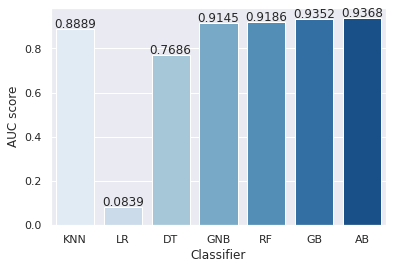

In [38]:
axis = sns.barplot(x = 'Name', y = 'AUC score', data = kf_cross_val, palette='Blues')
axis.set(xlabel='Classifier', ylabel='AUC score')
for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
    
plt.show()

We can see the best classifier is GB

Hyperparameter tuning and feature importance

In [39]:
clf = GradientBoostingClassifier(verbose=True)
clf.fit(X_train, y_train)
print('Train Score:', round(clf.score(X_train,y_train),3))
print('Test Score:', round(clf.score(X_test,y_test),3))

      Iter       Train Loss   Remaining Time 
         1           0.5968            1.77s
         2           0.5424            1.60s
         3           0.5036            1.52s
         4           0.4741            1.50s
         5           0.4506            1.48s
         6           0.4311            1.46s
         7           0.4152            1.42s
         8           0.4018            1.39s
         9           0.3906            1.35s
        10           0.3811            1.31s
        20           0.3336            1.08s
        30           0.3200            0.90s
        40           0.3101            0.76s
        50           0.3003            0.64s
        60           0.2953            0.52s
        70           0.2890            0.39s
        80           0.2823            0.26s
        90           0.2767            0.13s
       100           0.2715            0.00s
Train Score: 0.95
Test Score: 0.932


In [40]:
confusion_matrix(y_test, clf.predict(X_test))

array([[3116,   96],
       [ 150,  238]])

feature importance


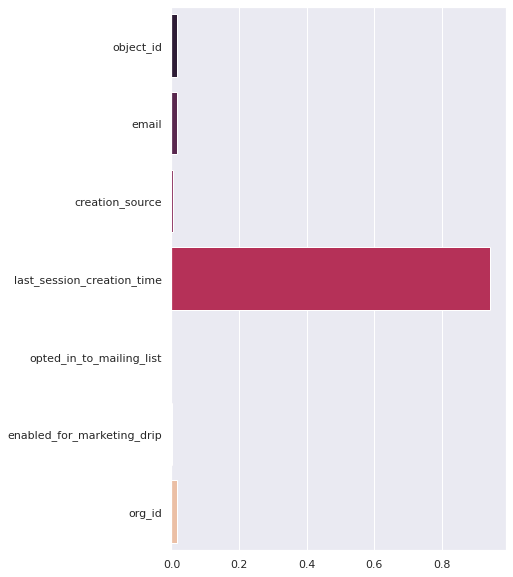

In [41]:
features = pd.Series(clf.feature_importances_, index=X.columns)
plt.figure(figsize=(6,10))
sns.barplot(y=X.columns, x=clf.feature_importances_, palette='rocket')
plt.show()

In [42]:
# Find feature importances
feature_importance = pd.DataFrame(clf.feature_importances_).T
feature_importance.columns = list(X_train.columns)
feature_importance = feature_importance.T
feature_importance.columns = ['feature_importance']
feature_importance.sort_values('feature_importance', ascending=False)

,feature_importance
last_session_creation_time,0.944373
email,0.016898
org_id,0.016811
object_id,0.016467
creation_source,0.003225
enabled_for_marketing_drip,0.002227
opted_in_to_mailing_list,0.000000


As we can see th emost important feature is last session creation time
